# Inicialização

In [15]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import math
from scipy.optimize import minimize


def kernel(xi,xj,parametros,D):
  lambda_f = parametros[0]
  somatorio = 0
  if D == 1:
    somatorio = lambda_f * math.e**( parametros[1] * ((xi-xj)**2) )
  else:
    for i in range(1,D+1):
      somatorio += parametros[i] * ((xi[i-1] - xj[i-1])**2)
  return lambda_f * math.e**(-somatorio/2)

def evidencia(parametros, X, y):
  N, D = X.shape
  I = np.eye(N)
  K= []
  for i in range(N):
    linha = []
    for j in range(N):
      for k in range(D):
        xik = X[i,k]
        xjk = X[j,k]
        Kij = kernel(xik, xjk, parametros, D)
        linha.append( Kij )
    K.append(linha)
  K = np.array(K)
  var_y = parametros[-1]
  return -1/2 * np.log(np.linalg.det(K + var_y * I)) - 1/2 * y.reshape(1,-1) @ np.linalg.inv(K + var_y * I) @ y.reshape(-1,1) - N/2 * math.log(math.pi * 2)

def NLPD_metric(X, y, y_pred, var_pred):
  N,D = X.shape
  return 1/2 * math.log(2*math.pi) + 1/2 * np.mean(np.log(var_pred) + (y - y_pred)**2 / var_pred)

treino = pd.read_csv("gp_data_test.csv").to_numpy()
teste = pd.read_csv("gp_data_test.csv").to_numpy()



# GP

In [16]:
class GP:
  def __init__(self, X, y, var_y = None):
    self.X = X
    N,D = X.shape
    self.y = y
    theta = np.random.randn(D+2)
    theta[0] = np.var(y)
    if var_y == None:
      theta[-1] = 0.01 * np.var(y)
    else:
      theta[-1] = var_y
    self.theta = theta

  def fit(self, n_it = 5):
    X = self.X
    N,D = X.shape
    y = self.y
    I = np.eye(N)
    self.I = I

    for _ in range(n_it):
      res = minimize( evidencia, self.theta, args = (X, y), method = "BFGS" )
      self.theta = res.x
    K= []
    for i in range(N):
      linha = []
      for j in range(N):
        for k in range(D):
          xik = X[i,k]
          xjk = X[j,k]
          Kij = kernel(xik, xjk, self.theta, D)
          linha.append( Kij )
      K.append(linha)
    K = np.array(K)
    self.K = K

  def pred(self, X_):
    N_ = X_.shape[0]
    X = self.X
    N,D = X.shape

    saida = []

    for i in range(N_):
      x_ = X_[i]

      kf_ = np.array([kernel(x_, X[j], self.theta, D) for j in range(N)])
      k__ = kernel(x_, x_, self.theta, D)

      media_ = kf_.T @ np.linalg.inv(self.K + self.theta[-1] * self.I) @ y
      dp_ = k__ - kf_.T @ np.linalg.inv(self.K + self.theta[-1] * self.I) @ kf_

      saida.append([media_[0], dp_[0,0]])

    return np.array(saida)

# Treino e Teste

In [17]:
X = treino[:,:-1]
y = treino[:,-1]

X_ = teste[:,:-1]
y_ = teste[:,-1]

model = GP(X,y)
model.fit(n_it = 5)
saida = model.pred(X_)
media_pred = saida[:,0]
var_pred = saida[:,1]

df = pd.DataFrame()
df["media"] = media_pred
df["real"] = y_


<ipython-input-15-d3515246d728>:33: RuntimeWarning: divide by zero encountered in log
  return -1/2 * np.log(np.linalg.det(K + var_y * I)) - 1/2 * y.reshape(1,-1) @ np.linalg.inv(K + var_y * I) @ y.reshape(-1,1) - N/2 * math.log(math.pi * 2)
/usr/local/lib/python3.10/dist-packages/scipy/optimize/_numdiff.py:576: RuntimeWarning: invalid value encountered in subtract
  df = fun(x) - f0


# Resultados

## Métricas

In [20]:
from sklearn.metrics import mean_squared_error

rmse = np.sqrt(mean_squared_error(y_, media_pred))
nlpd = NLPD_metric(X_, y_, media_pred, var_pred)
# Infelizmente o nlpd ficou com um valor muito alto porque a variância das amostras ficaram bem pequenas e eu não consegui identificar o problema

print("RMSE:", rmse)
print("NLPD:", nlpd)

RMSE: 0.25474839787460374
NLPD: 1628.8583932532645


## Gráfico

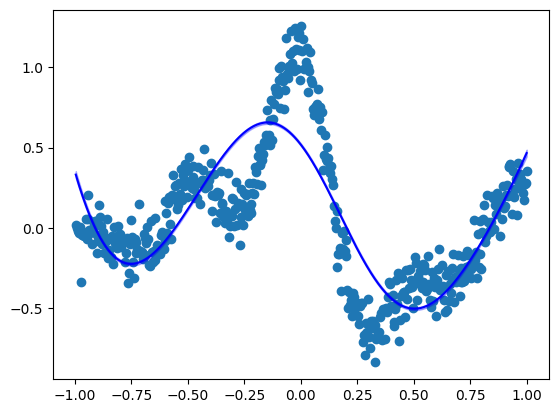

In [21]:
plt.scatter(X_, y_)
plt.plot(X_, media_pred, 'b')
plt.fill_between(X_.flat, media_pred-2*np.sqrt(var_pred),
                 media_pred+2*np.sqrt(var_pred), color='blue', alpha=0.3)
plt.show()